In [1]:
import sys
sys.path.insert(1, '/home/nicolas/Documents/Stage/code/stage/src/')
sys.path.insert(1, '/home/nicolas/Documents/Stage/code/stage/data/')

import torch
import rbm
import functions
import time
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
import gzip
import math
import torch.optim as optim
from BinaryClassifier import BinaryClassifier, train, test
from ComparisonDataset import ComparisonDataset
#device = torch.device("cpu")
device = torch.device("cuda")
dtype = torch.float
from torch.optim.lr_scheduler import StepLR

Le but $\rightarrow$ essayer une métrique "par classifieur" de nos données générés
 * générer 10000 données artificiellement de MNIST à l'aide d'une RBM déjà entrainée
 * créer les labels en accord:
     - 1 pour les données générées
     - 0 pour les données MNIST
 * entrainer un classifieur sur notre jeu de données
     - Le séparer en train + test (70%/30%??)
     - entrainer sur le train
     - valider et évaluer sur le test 
 * s'en servir pour évaluer de nouvelles données générées

In [2]:
net = BinaryClassifier()
net.cuda()
train_set = ComparisonDataset(device, data_file = 'data/data.pt', label_file = 'data/labels.pt',  train = True)
test_set = ComparisonDataset(device, data_file = 'data/data.pt', label_file = 'data/labels.pt', train = False)

In [3]:
train_kwargs = {'batch_size': 128}
test_kwargs = {'batch_size': 1000}
cuda_kwargs = {'num_workers': 0,
                       'pin_memory': False,
                       'shuffle': False}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)
train_loader = torch.utils.data.DataLoader(train_set,**train_kwargs)
test_loader = torch.utils.data.DataLoader(test_set, **test_kwargs)

In [4]:
optimizer = optim.Adadelta(net.parameters(), lr=0.1)

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(1, 100 + 1):
    train(net, device, train_loader, optimizer, epoch)
    test(net, device, test_loader)
    scheduler.step()

In [5]:
torch.linalg.norm(net(test_set.data[:2500].cuda()).round().view(2500)-test_set.label[:2500].cuda(), 1).item()*100/2500


33.4

0.0

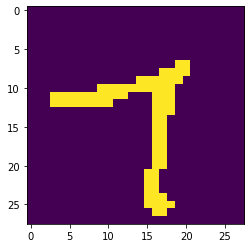

In [6]:
import matplotlib.pyplot as plt
id = torch.randint(len(test_set.data), (1,1))
plt.imshow(test_set.data[id].view(28,28).cpu())
test_set.label[id].item()

In [7]:
test_set.label[:100].cuda().shape

torch.Size([100])